## Import libraries

In [1]:
import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as Fun
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook

In [2]:
path = os.path.abspath("../Model")
sys.path.append(path)
from My_ViT import VisionTransformer


## Setting some parameters

In [3]:
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Device:", device)

Device: mps


In [4]:
image_size = 28
embed_dim=255
hidden_dim=embed_dim*3
num_heads=3
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2
epochs=20

## Downloading MNIST from torchvision

In [5]:
# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))
                                                   ])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

In [6]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(train_loader,'training loader')
print_dim(val_loader,'validation loader')
print_dim(test_loader,'test loader')

---------training loader---------
50000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------validation loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------test loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])


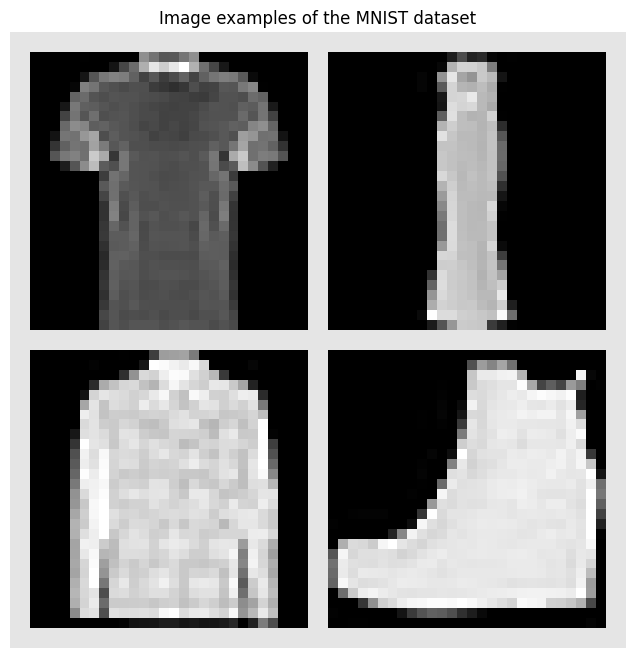

In [7]:
# Visualize some examples
NUM_IMAGES = 4
MNIST_examples = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

## Visualizing `img_to_patch` function

In [8]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], MNIST [B, 1, 28, 28]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], MNIST [B, 1, 4, 7, 4, 7]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], MNIST [B, 4, 4, 1, 7, 7]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], MNIST [B, 16, 1, 7, 7]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], MNIST [B, 16, 49]
    return x

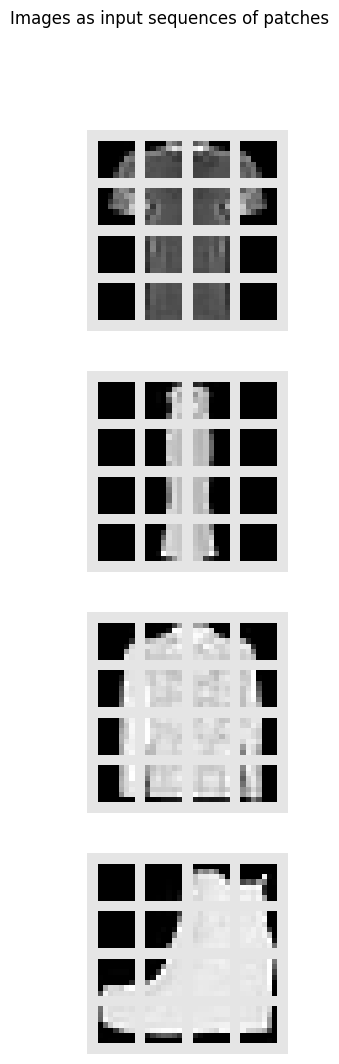

In [9]:
# Visualize the image patches
img_patches = img_to_patch(MNIST_examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(MNIST_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

## Initializing the model

In [10]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          dropout=dropout)

# Transfer to GPU
model.to(device)
model_restore = None #'/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True

In [11]:
model

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=255, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((255,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=255, out_features=255, bias=True)
      )
      (layer_norm_2): LayerNorm((255,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=255, out_features=765, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=765, out_features=255, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((255,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=255, out_features=255, bias=True)
      )
      (layer_norm_2): Layer

## Training

In [12]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)
# set a scheduler to decay the learning rate by 0.1 on the 100th 150th epochs
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer,
                                            milestones=[100, 150], gamma=0.1)

# set an empty list to plot the loss later
lossi = []
# set an initial high value for the validation loss
best_vloss = 1_000_000
# set the timestamp to save the training model
timestamp = datetime.now().strftime('%Y%m%d_%H:%M:%S')
# Training loop
for epoch in range(epochs):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model(imgs)
    # Compute the loss and its gradients
    loss = loss_fn(preds, labels)
    # append this loss to the list for later plotting
    lossi.append(loss.item())
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_optimizer.step()

  # step the scheduler for the learning rate decay
  model_scheduler.step()
  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {:.4f} valid {:.4f}'.format(loss.item(), avg_vloss.item()))

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = './mmmodel_VisionTransformer_MNIST_{}.pt'.format(epoch+1)
      torch.save(model, './training.pth')

epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.4160 valid 0.4641


epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.5956 valid 0.3883


epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0554 valid 0.3891


epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.4954 valid 0.3677


epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1867 valid 0.3639


epoch 5:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1740 valid 0.3716


epoch 6:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.3037 valid 0.3499


epoch 7:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.4205 valid 0.3732


epoch 8:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.7154 valid 0.3436


epoch 9:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.4811 valid 0.3564


epoch 10:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2292 valid 0.3477


epoch 11:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2780 valid 0.3429


epoch 12:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.3166 valid 0.3248


epoch 13:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2437 valid 0.3294


epoch 14:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1304 valid 0.3315


epoch 15:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.3618 valid 0.3196


epoch 16:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2494 valid 0.3164


epoch 17:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0900 valid 0.3161


epoch 18:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1447 valid 0.3228


epoch 19:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1159 valid 0.3123


Text(0.5, 1.0, 'Training loss')

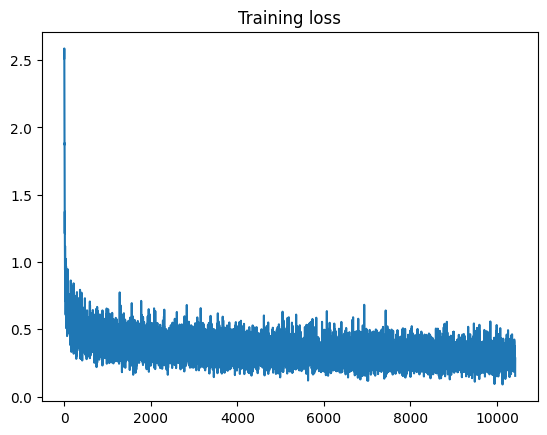

In [13]:
# plot the training loss by averaging every 3 steps
fig = plt.figure()
ax = fig.add_subplot(111)
# plot the average loss
plt.plot(torch.tensor(lossi).view(-1, 3).mean(1))
plt.title('Training loss')

In [14]:
# Set the model to evaluation mode, disabling dropout.
model.eval()
# evaluate network
acc_total = 0
with torch.no_grad():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 0.8828
